In [15]:
import importlib

import numpy as np
from matplotlib import pyplot as plt

import scipy
from scipy.optimize import LinearConstraint, Bounds

# Our first optimal control problem
Consider a car moving on a straight line modeled by the simple double integrator dynamics
$$\dot{p} = v$$
$$\dot{v} = u$$ 
where $p$ is car's position and $v$ its velocity. The control problem is to find the car acceleration $u(t)$ for each instant of time.

## Discretization
We discretize the dynamics using a small $\Delta t$ and Euler integration
$$p_{n+1} = p_n + \Delta t \ v_n$$
$$v_{n+1} = v_n + \Delta t \ u_n$$ 

## Optimal control problem
We can now write down our discrete time optimal control problem. Here we will choose a quadratic cost
$$\begin{align}
& \min_{p_n, v_n, u_n} \sum_{n=0}^N u_n^2\\
\textrm{subject to} \ \ \ \ & p_{n+1} = p_n + \Delta t \ v_n\\
& v_{n+1} = v_n + \Delta t \ u_n\\
& p_0 = p_{init}\\
& p_{N+1} = p_{goal}\\
& v_0 = v_{N+1} = 0\\
& u_{min} \leq u_n \leq u_{max}
\end{align}$$

This is an optimization problem where the variables to find are $p_0, v_0, u_0, p_1, \cdots, p_N, v_N, u_N$. We can then use any optimization algorithm that can deal with constraints. For example, we use the [SLSQP solver](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html#optimize-minimize-slsqp) from SciPy (i.e. the function minimize called with the right parameters). The documentation of the solver can be found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize).

## Implementing everything
Below we show how to solve the problem with this "black-box" optimizer. Feel free to change the cost function `objective` and any other parameter and see how the solution changes. The solver we use asks us to create a "bound" object to setup min and max values for the states and control as well as a linear constraint object to define $Ax=b$.

Note that to get our equality constraints in the form $Ax = b$ - setting $x = [p_0, v_0, u_0, p_1, v_1, \cdots, u_N, p_{N+1}, v_{N+1}]$ we can rewrite the equality constraints as
\begin{align}
\begin{bmatrix} 
1 & 0 & 0 & 0 & 0 & 0 &\cdots & 0 & 0 & 0\\
0 & 1 & 0 & 0 & 0 & 0 &\cdots & 0 & 0 & 0\\
1 & 0.01 & 0 & -1 & 0 & 0 &\cdots & 0 & 0 & 0\\
0 & 1 & 0.01 & 0 & -1 & 0 &\cdots & 0 & 0 & 0\\
0 & 0 & 0 & 1 & 0.01 & 0 &\cdots & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 1 & 0.01 &\cdots & 0 & 0 & 0\\
\vdots & \vdots &  & &  \cdots & \vdots & \vdots & \vdots\\
0 & 0 & 0 & 0 & 0 &0 &\cdots & 0 & -1 & 0\\
0 & 0 & 0 & 0 & 0 &0 &\cdots & 0.01 & 0 & -1\\
0 & 0 & 0 & 0 & 0 &0 &\cdots & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 0 &0 &\cdots & 0 & 0 & 1\\
\end{bmatrix}
\begin{pmatrix}
p_0\\ v_0\\ u_0\\ p_1\\ v_1\\ \vdots\\ u_N\\ p_{N+1}\\ v_{N+1}
\end{pmatrix}
= \begin{pmatrix}
p_{init}\\ 0\\ 0\\ 0\\ 0\\ 0 \\ \vdots\\ 0\\ 0\\ p_{goal}\\ 0
\end{pmatrix}
\end{align}
where the first line of the matrix just enforces that $p_0 = p_{init}$, the second one $v_0 = 0$, the third one $p_n + \Delta t \ v_n - p_{n+1} = 0$, the fourth one $v_n + \Delta t \ u_n - v_{n+1} = 0$, for all the constraints. The last two lines enforce $p_{N+1} = p_{goal}$ and $v_{N+1} = 0$.


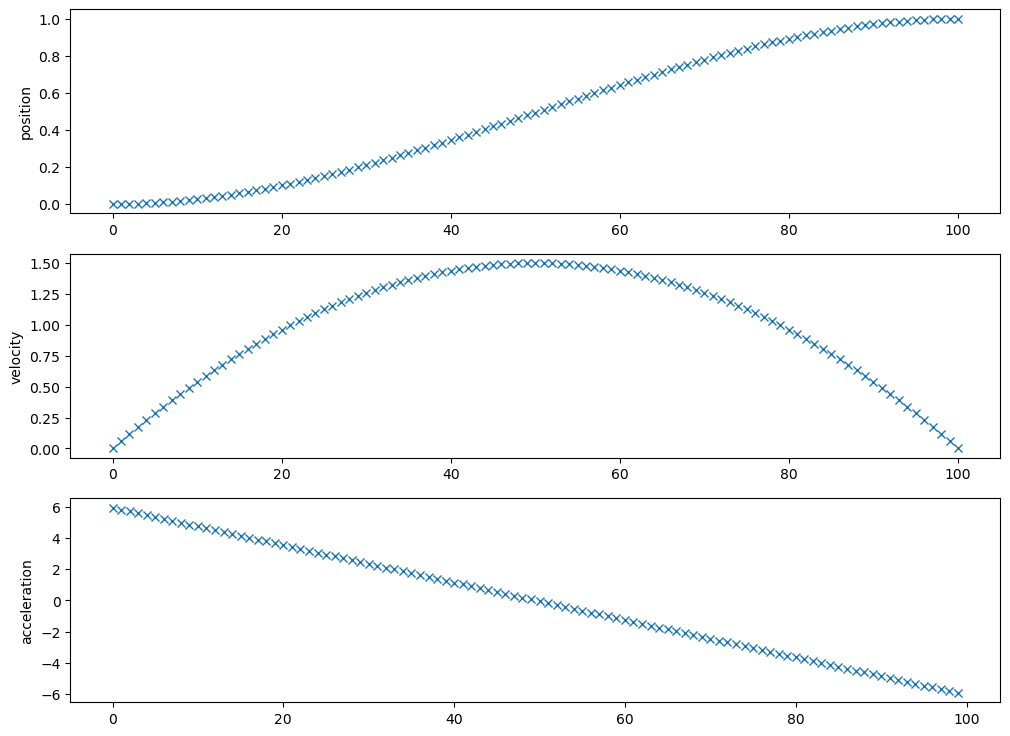

In [11]:
# we define a few constants
xdim = 2 # dimension of the state (p,v)
udim = 1 # dimension of the control (u)
N = 100 # number of steps
nvars = N*udim + (N+1)*xdim # total number of variables
dt = 0.01 #delta t
p_init = 0. # initial position of the car
p_goal = 1. # final position of the car

## In the following we assume we have our vector of unknowns x as (p0, v0, u0, p1, v1, etc)
x0 = np.zeros((nvars)) # vector of initial guess


def objective(x):
    ''' 
    the objective function to minimize (here u*u)
    feel free to change it
    '''
    p = x[0::(xdim+udim)]
    v = x[1::(xdim+udim)]
    u = x[2::(xdim+udim)]

    return u.T @ u


## create a bound umax for the solver
u_max = 10.085
lower_bound = np.full((nvars),-np.inf)
upper_bound = np.full((nvars),np.inf)
for i in range(N):
    lower_bound[i*(xdim+udim)+xdim] = -u_max
    upper_bound[i*(xdim+udim)+xdim] = u_max
bounds = Bounds(lower_bound, upper_bound)

## create the linear model
A = np.zeros([xdim * (N+2), nvars])
b = np.zeros([xdim * (N+2)])

A[0:2, 0:2] = np.eye(2)
b[0] = p_init
b[-2] = p_goal
A[-2:,-2:] = np.eye(2)
for i in range(N):
    ##u
    A[(i+1)*xdim:(i+2)*xdim, i*(xdim+udim)+xdim:i*(xdim+udim)+xdim+1] = np.array([[0], [dt]])
    ##x n+1
    A[(i+1)*xdim:(i+2)*xdim, (i+1)*(xdim+udim):(i+1)*(xdim+udim)+xdim] = np.array([[-1, 0],[0,-1]])
    ## xn
    A[(i+1)*xdim:(i+2)*xdim, i*(xdim+udim):(i)*(xdim+udim)+xdim] = np.array([[1, dt],[0,1]])

linear_constraint = LinearConstraint(A, b, b)


## call the optimizer
res = scipy.optimize.minimize(objective, x0, method='SLSQP', constraints=linear_constraint, bounds=bounds)


## plot the result if successful
if res.success:
    p = res.x[0::3]
    v = res.x[1::3]
    u = res.x[2::3]

    plt.figure(figsize=[12,9])
    plt.subplot(3,1,1)
    plt.ylabel('position')
    plt.plot(p, 'x')
    plt.subplot(3,1,2)
    plt.ylabel('velocity')
    plt.plot(v, 'x')
    plt.subplot(3,1,3)
    plt.plot(u, 'x')
    plt.ylabel('acceleration')
else:
    print('Failed')